In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split


In [34]:
train = pd.read_csv('./open/train.csv')
test = pd.read_csv('./open/test.csv')

In [35]:
train['대출기간'] = train['대출기간'].apply(lambda x:x[:3])
train['대출기간'] = train['대출기간'].astype('int64')
test['대출기간'] = test['대출기간'].apply(lambda x:x[:3])
test['대출기간'] = test['대출기간'].astype('int64')

trans = {'1 year':1,
 '1 years':1,
 '10+ years':12,
 '10+years':12,
 '2 years':2,
 '3':3,
 '3 years':3,
 '4 years':4,
 '5 years':5,
 '6 years':6,
 '7 years':7,
 '8 years':8,
 '9 years':9,
 '< 1 year':0.5,
 '<1 year':0.5,
 'Unknown':0}
train['근로기간'] = [trans[i] for i in train['근로기간'].values]
test['근로기간'] = [trans[i] for i in test['근로기간'].values]
train.loc[train[train['부채_대비_소득_비율'] == 9999].index,'부채_대비_소득_비율'] = 2000
test.loc[test[test['부채_대비_소득_비율'] == 9999].index,'부채_대비_소득_비율'] = 2000
# train = pd.get_dummies(train, columns=['주택소유상태','대출목적'])
# test = pd.get_dummies(test, columns=['주택소유상태','대출목적']) # c
# train = train.drop(['주택소유상태','대출목적','근로기간','연간소득','총계좌수','연체계좌수','총연체금액','최근_2년간_연체_횟수'],axis=1)
# test = test.drop(['주택소유상태','대출목적','근로기간','연간소득','총계좌수','연체계좌수','총연체금액','최근_2년간_연체_횟수'],axis=1)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for tt in ['주택소유상태','대출목적']:
    train[tt] = le.fit_transform(train[tt])
    test[tt] = le.fit_transform(test[tt])

train = train.drop('ID',axis=1)
test = test.drop('ID',axis=1)

target = ['A','B','C','D','E','F','G']
ordinal_mapping = {target[i]:i for i in range(len(target))}
train['대출등급'] = train['대출등급'].map(ordinal_mapping)

In [36]:
train.columns = ['loan_amount', 'loan_term', 'employment_duration', 'home_ownership_status', 
 'annual_income', 'debt_to_income_ratio', 'total_accounts', 'loan_purpose', 
 'recent_2_years_delinquency_count', 'total_principal_repaid', 'total_interest_repaid', 
 'total_overdue_amount', 'number_of_delinquent_accounts', 'loan_grade']
test.columns = ['loan_amount', 'loan_term', 'employment_duration', 'home_ownership_status', 
 'annual_income', 'debt_to_income_ratio', 'total_accounts', 'loan_purpose', 
 'recent_2_years_delinquency_count', 'total_principal_repaid', 'total_interest_repaid', 
 'total_overdue_amount', 'number_of_delinquent_accounts']


<Axes: >

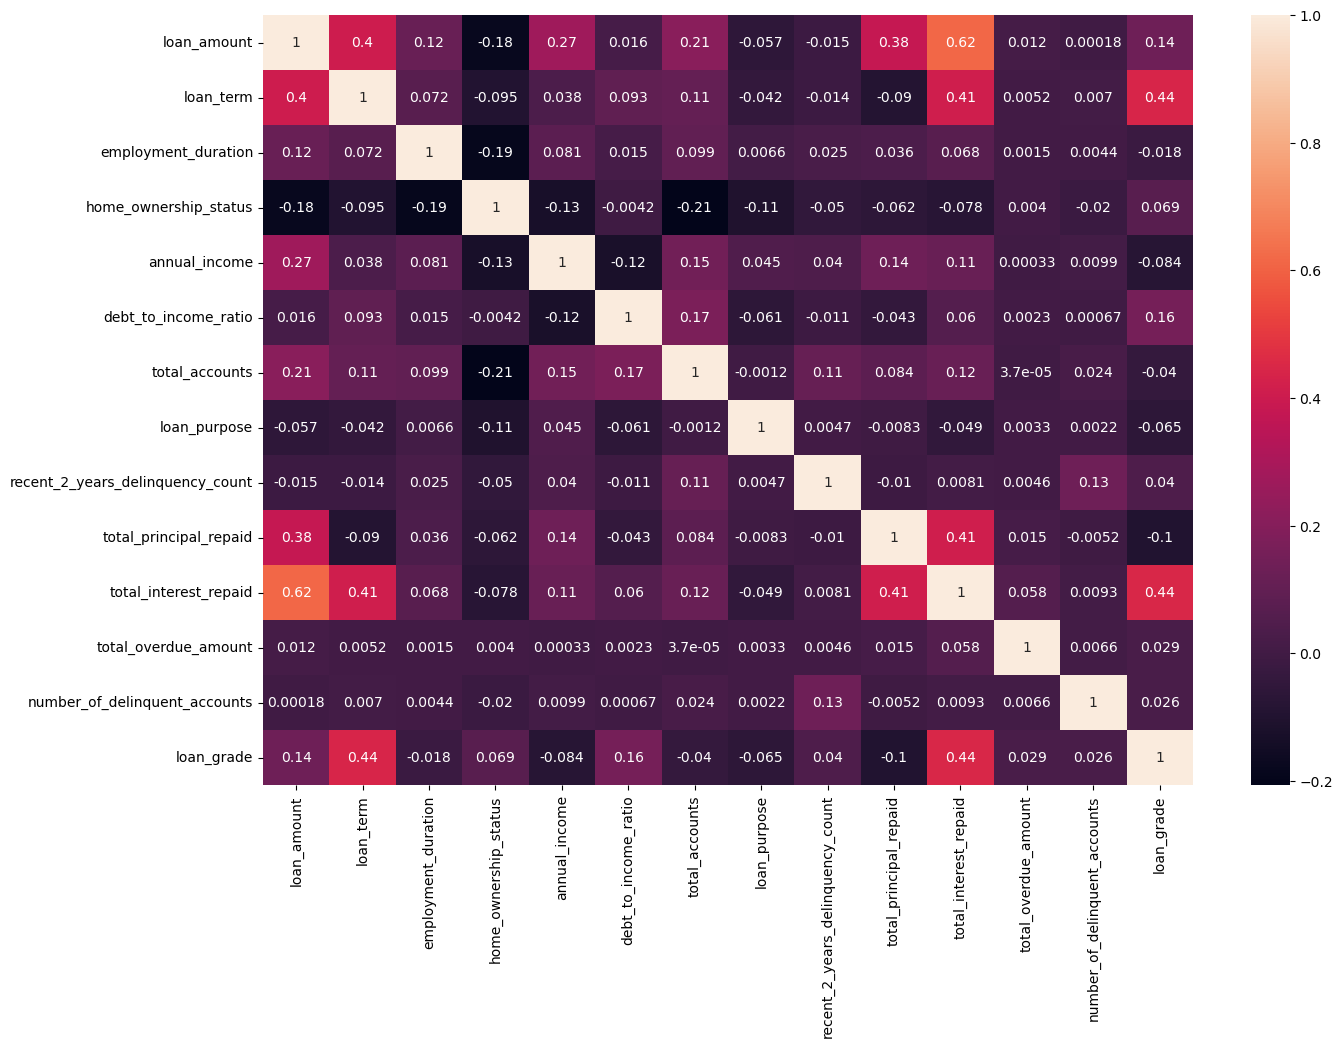

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
sns.heatmap(train.corr(),annot=True)

In [24]:
# from pycaret.classification import *
# target = 'loan_grade'
# X = train.drop(target,axis=1)
# y = train[[target]]
# test_ratio = 0.2
# cut_ratio = 0.1


# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=test_ratio, stratify=y, random_state=42
# )

# # PyCaret에서 사용할 데이터 프레임 생성 (실제 데이터에 맞게 설정 필요)
# data = pd.concat([X_train, y_train], axis=1)

# # PyCaret의 setup 함수를 사용하여 실험 환경 설정
# exp1 = setup(data, target='loan_grade', fold=10, session_id=42)

# # 모델 비교
# best_model = compare_models(sort='F1', fold=10) # , include=['lightgbm', 'xgboost', 'catboost'])

# # best_model로 훈련
# final_model = finalize_model(best_model)

# # 테스트 데이터에 대한 예측
# predictions = predict_model(final_model, data=X_test)

# # Macro F1 Score 출력
# macro_f1_score = f1_score(y_test, predictions['predction_label'], average='macro')
# print(f"Macro F1 Score on Test Data: {macro_f1_score:.4f}")


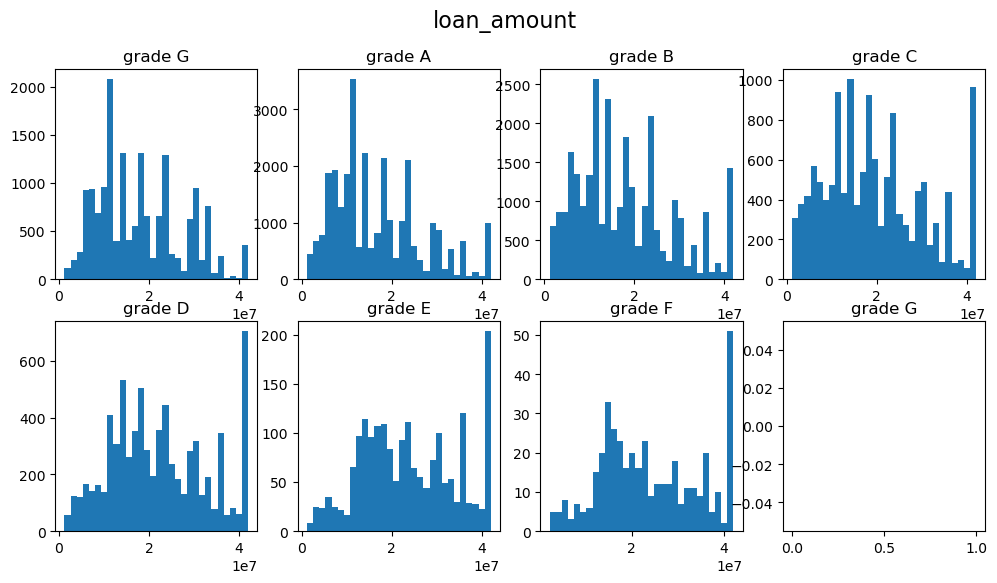

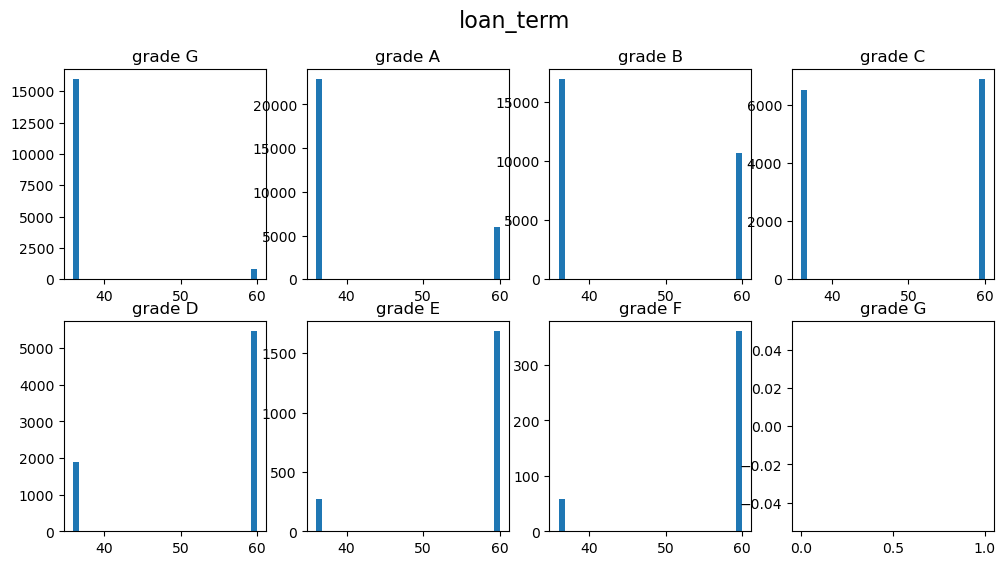

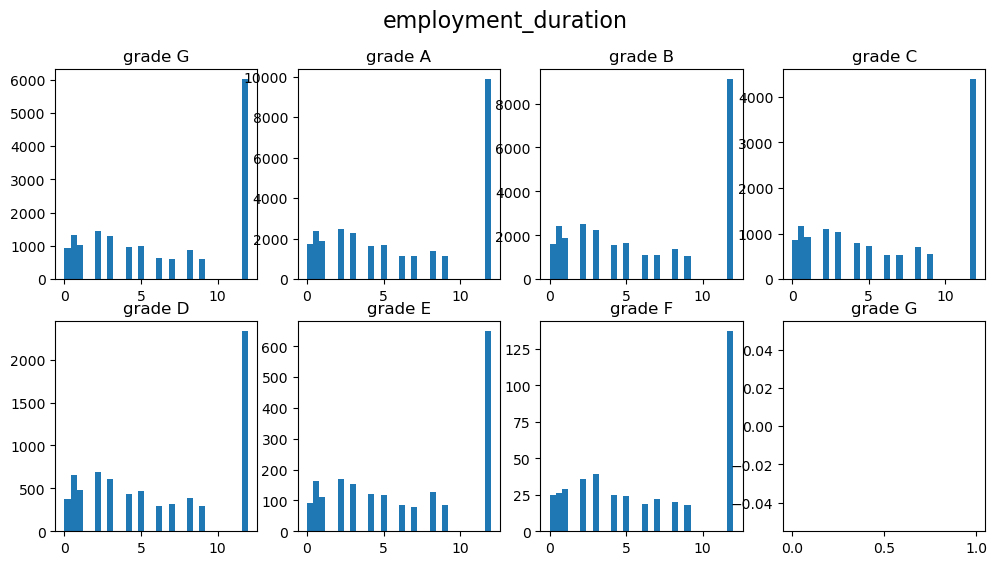

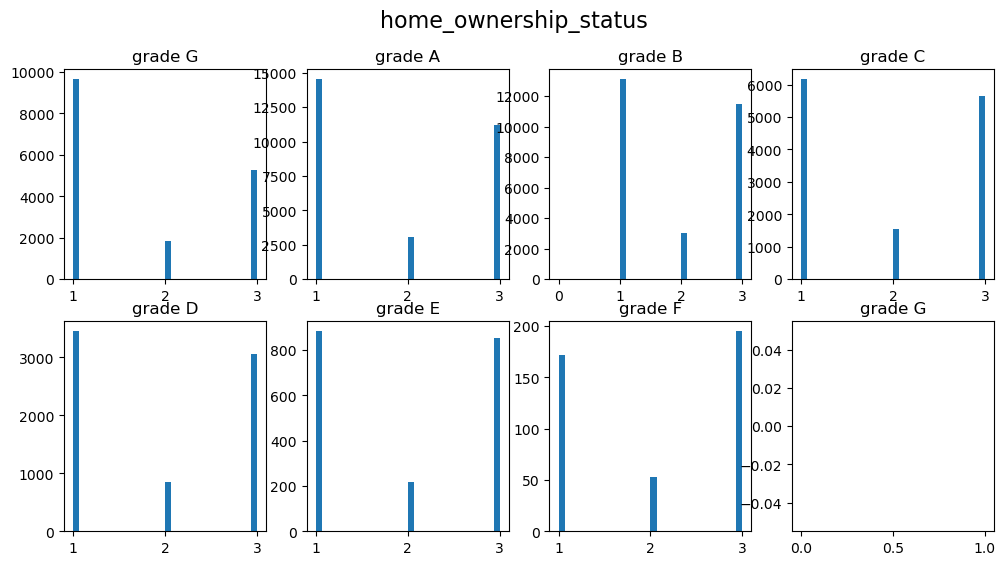

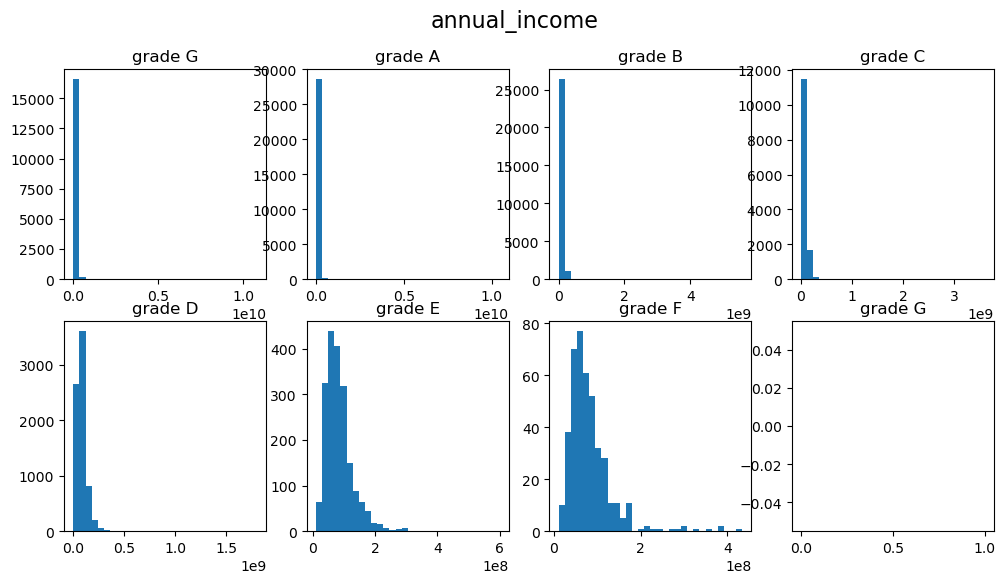

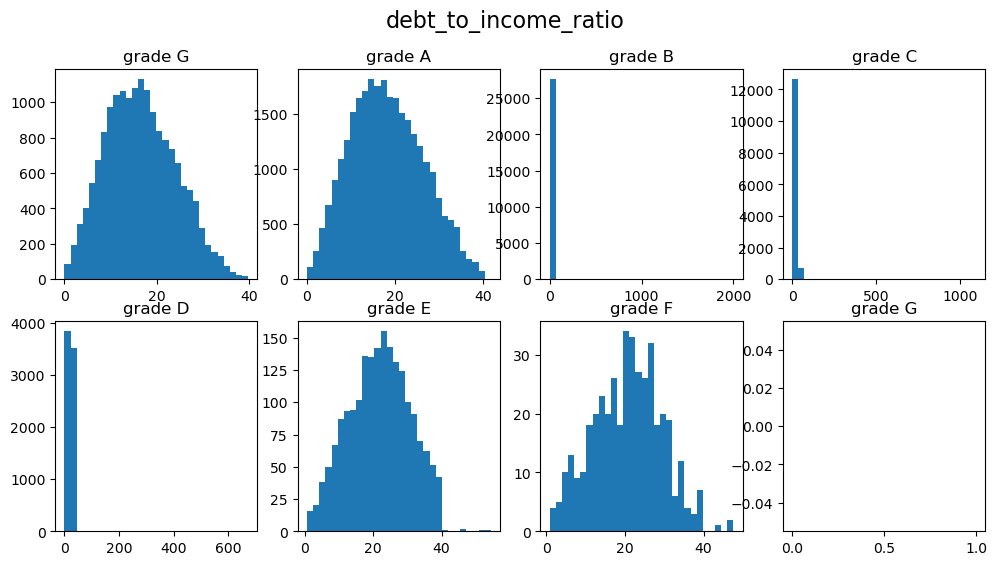

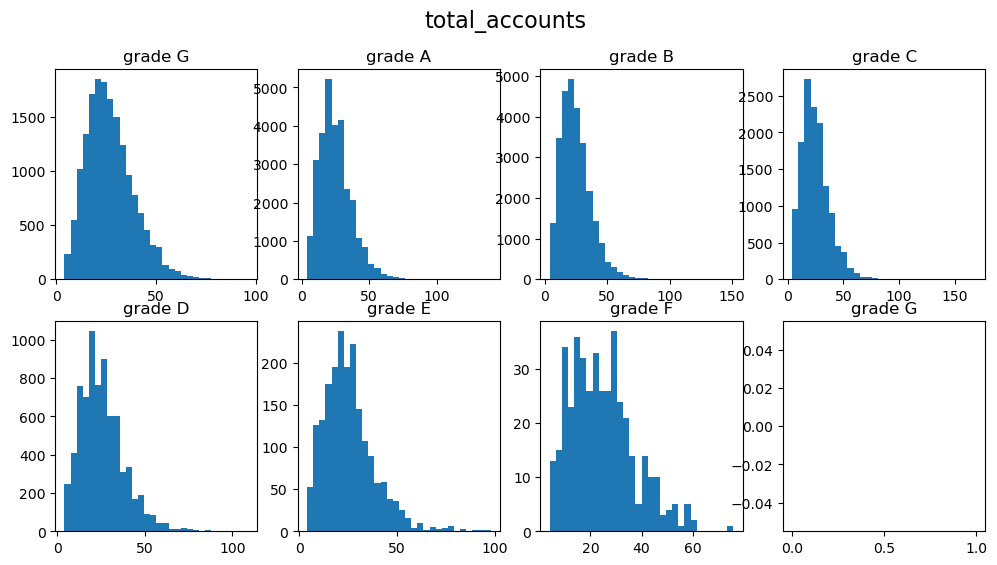

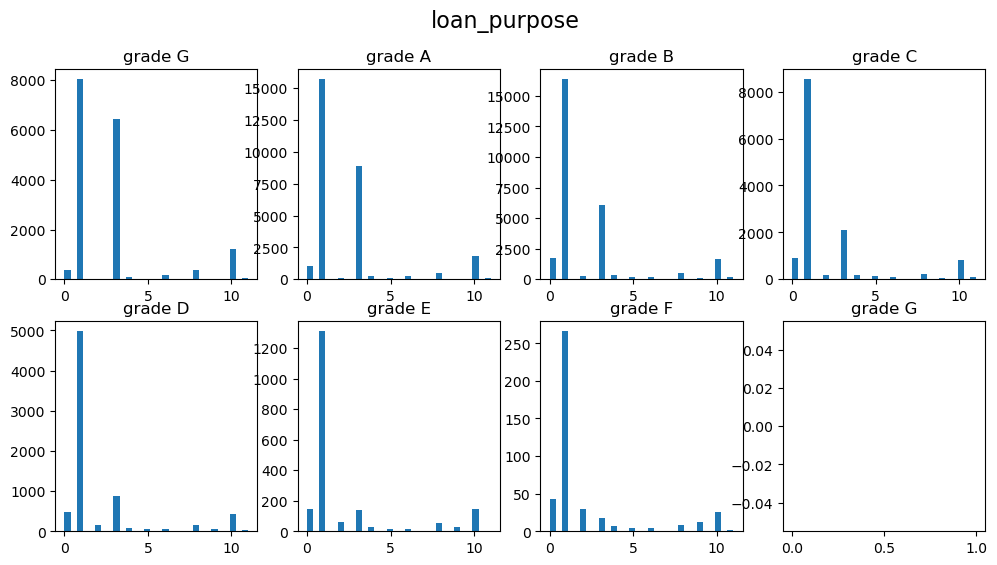

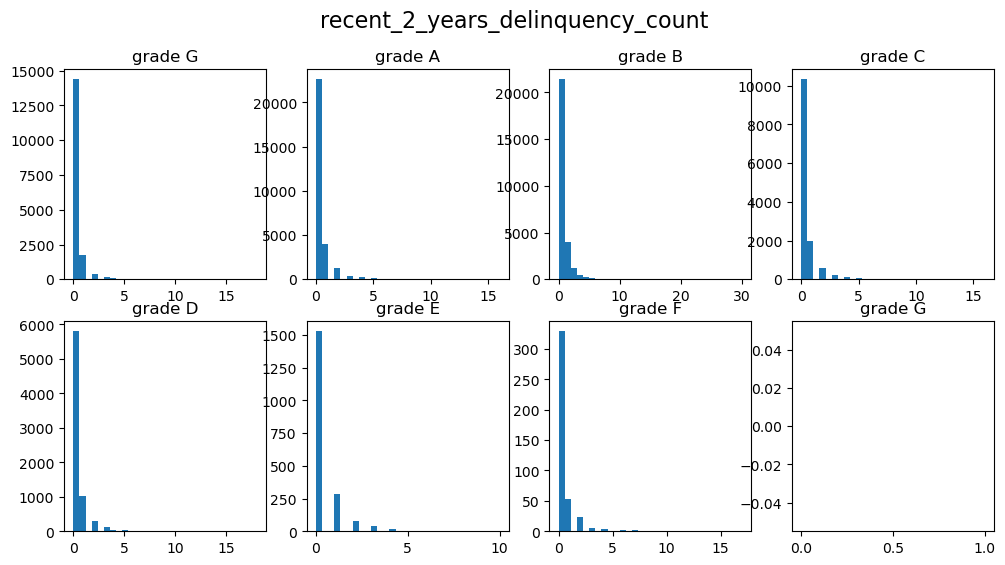

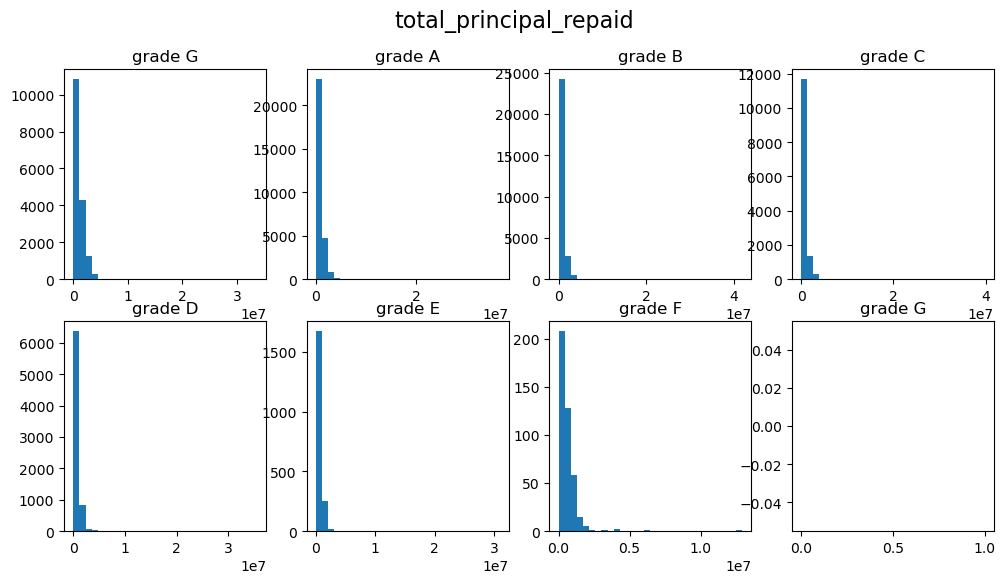

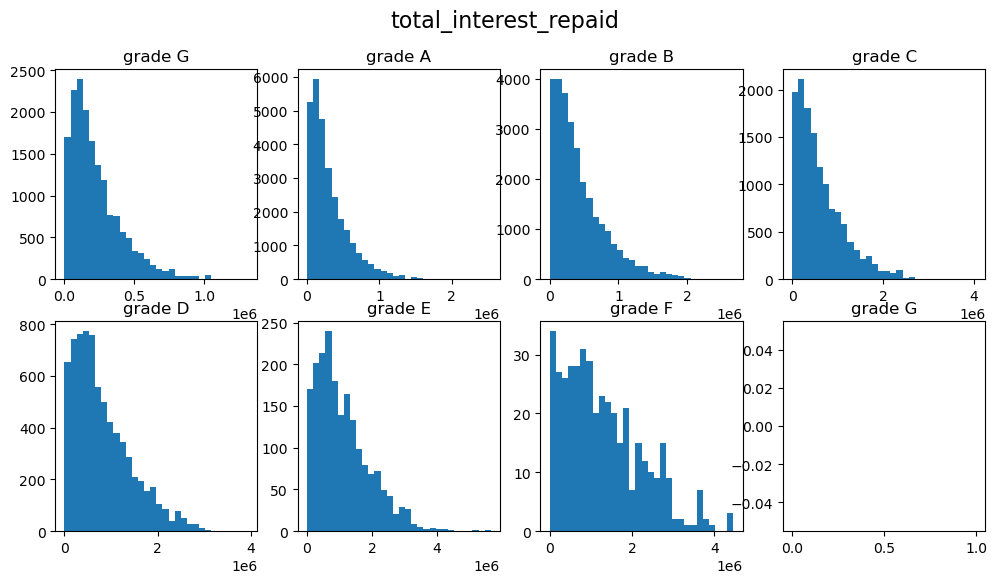

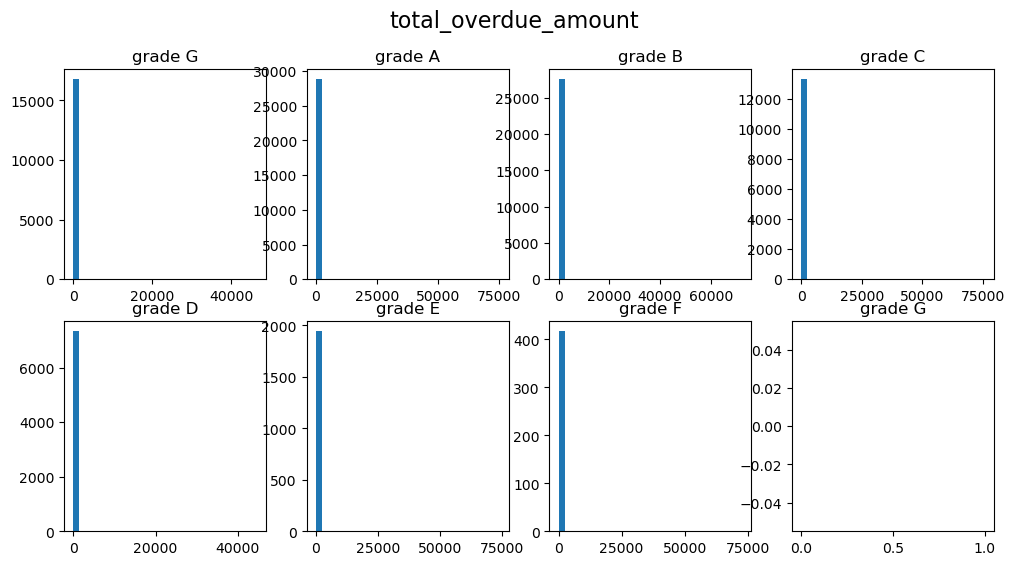

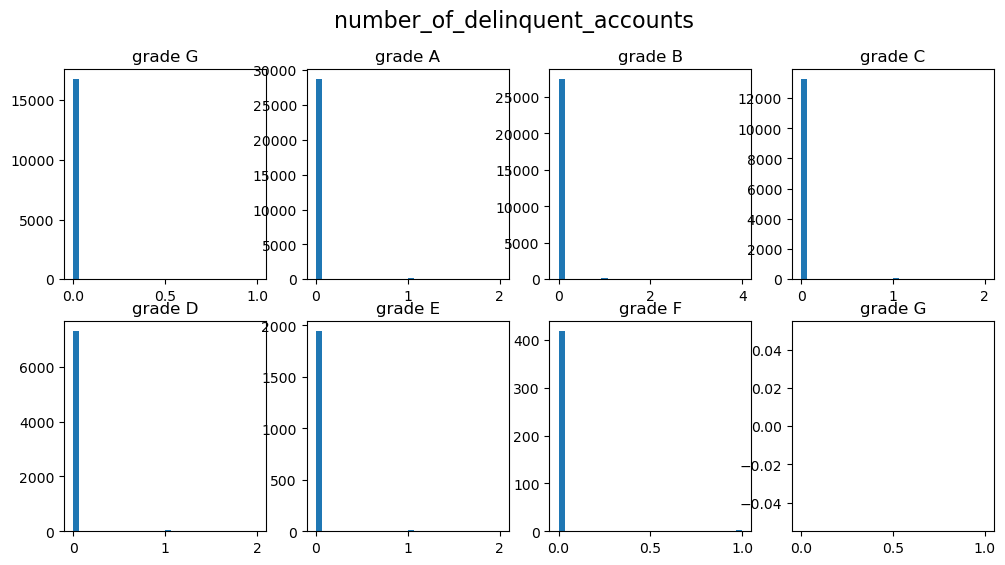

In [6]:
import seaborn as sns
from tqdm import tqdm
target = ['A','B','C','D','E','F','G']
    
def make_rpt(col):
    k = 0
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
    for i in range(2):
        for j in range(4):
            if k > len(target):
                continue
            ax = axes[i, j]
            data = train[train['loan_grade'] == k][col]
            ax.hist(data,bins=30)
            ax.set_title(f'grade {target[k-1]}')
            k += 1
    plt.suptitle(col, fontsize=16)

for tar in test.columns:
    make_rpt(tar)
    plt.show()

C:\Users\User\anaconda3\envs\project\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\anaconda3\envs\project\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


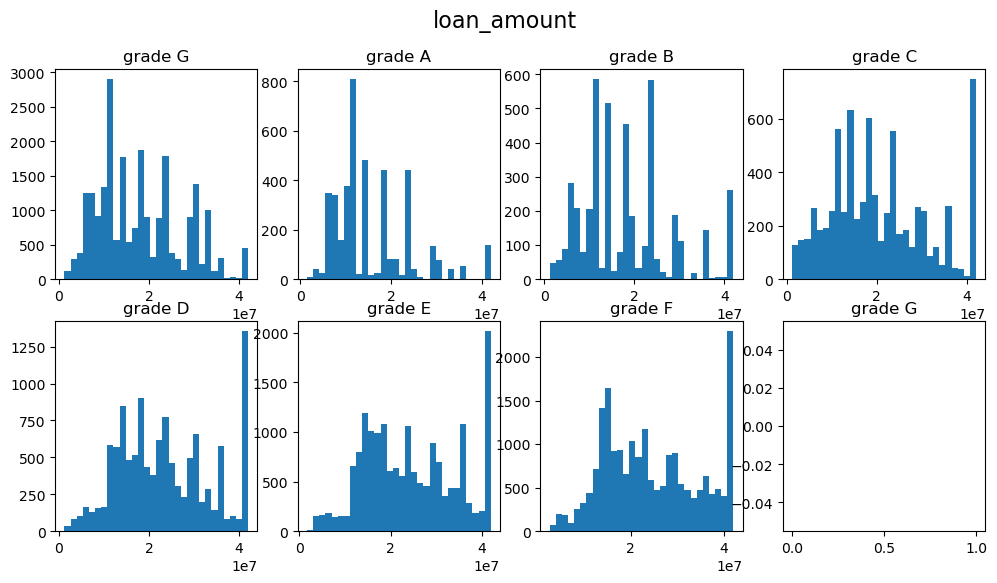

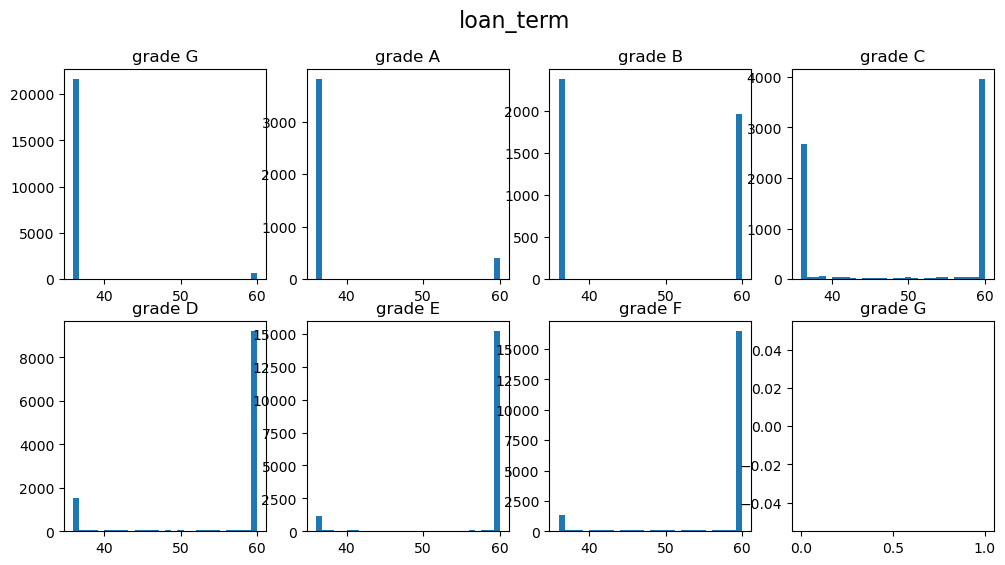

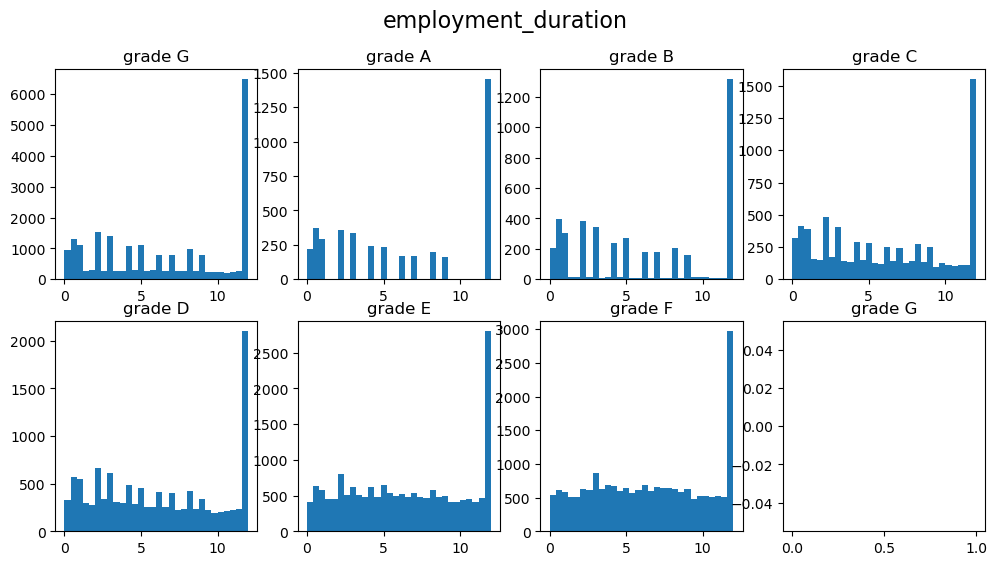

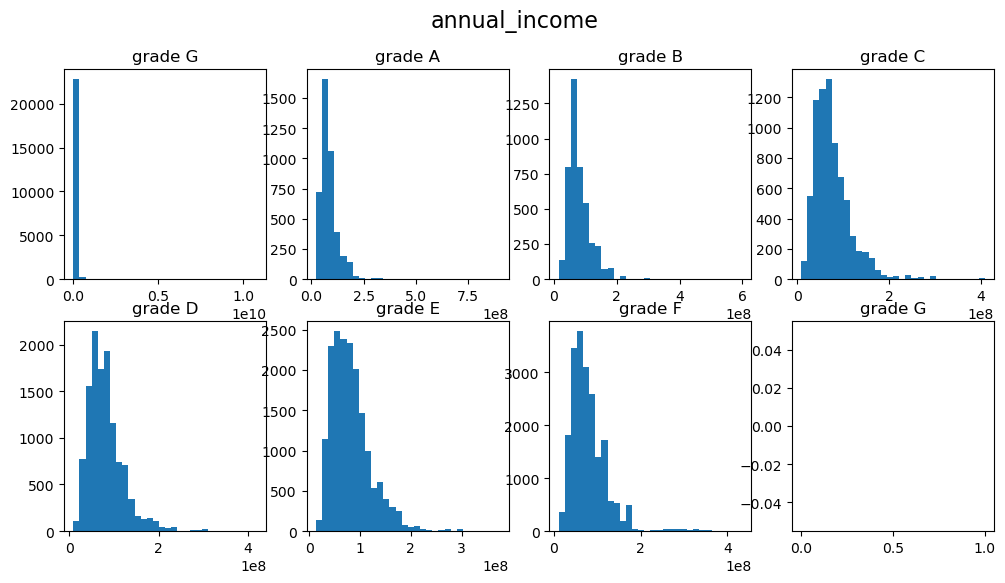

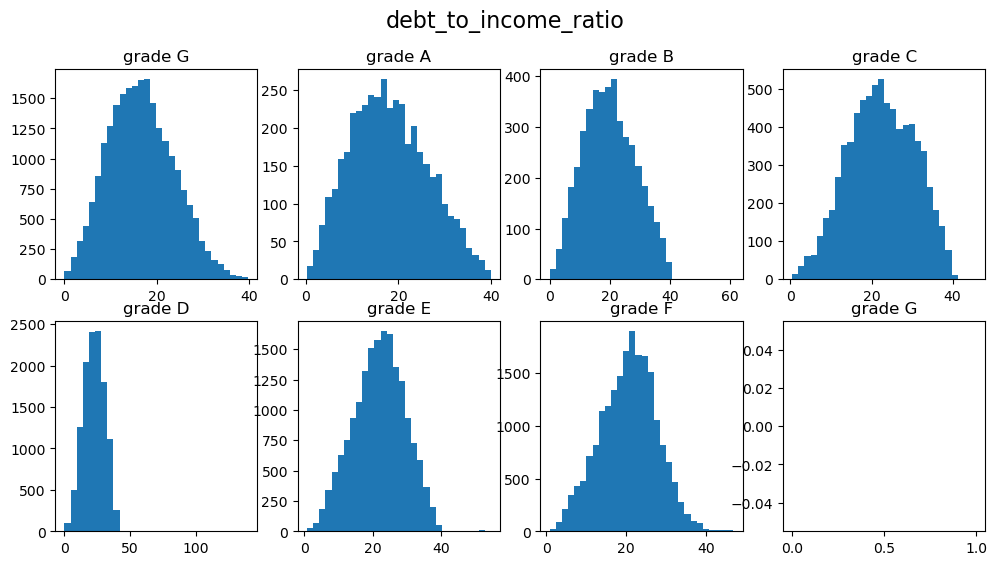

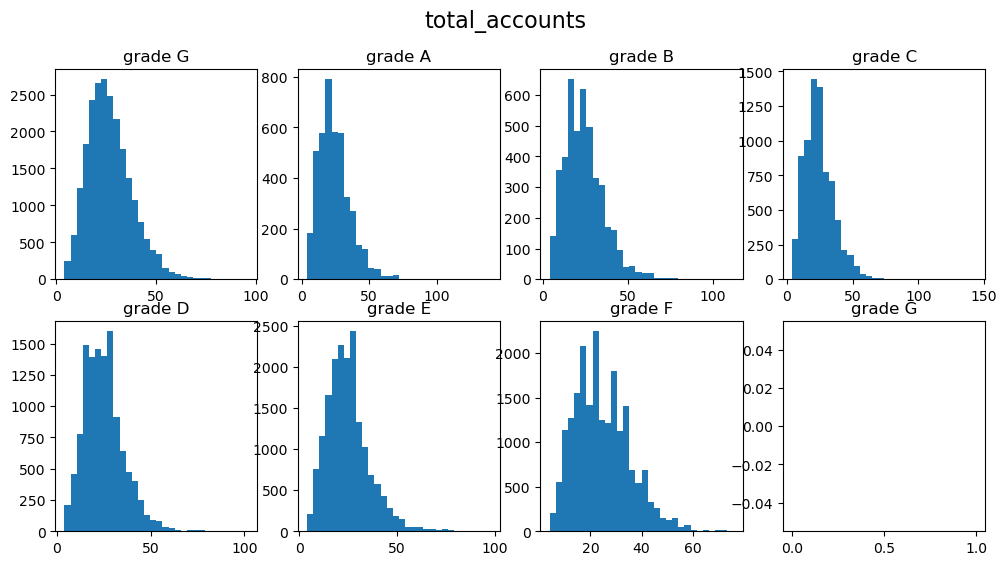

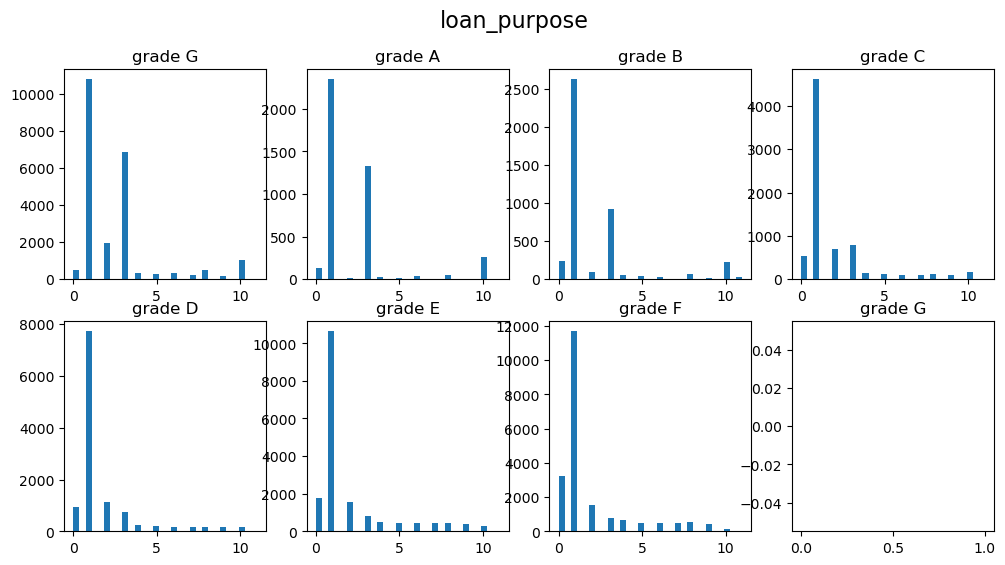

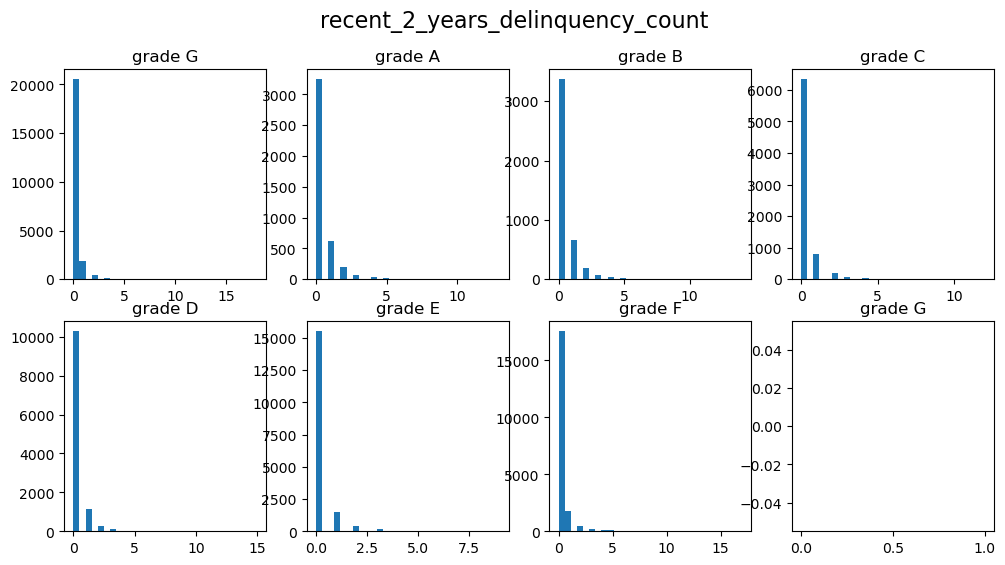

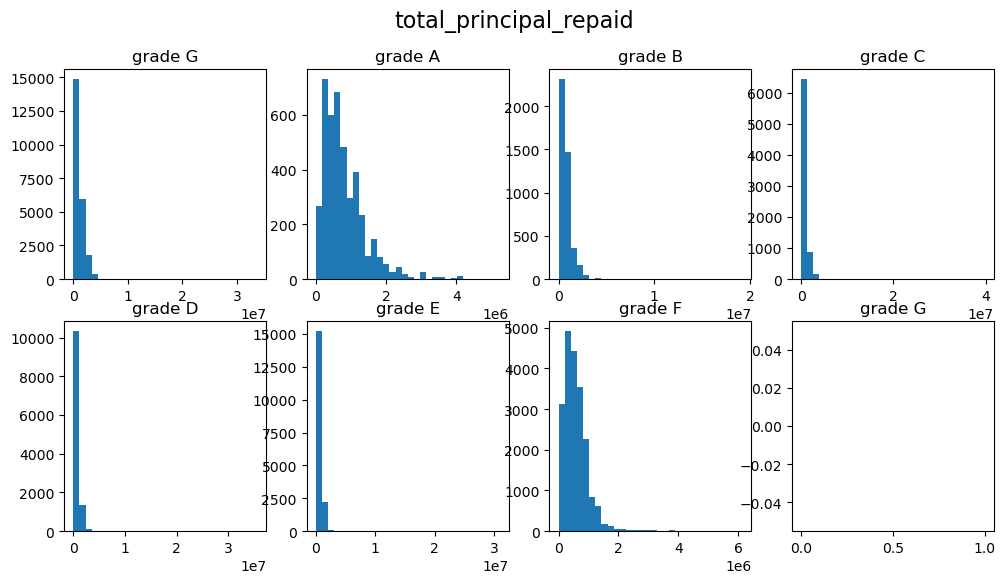

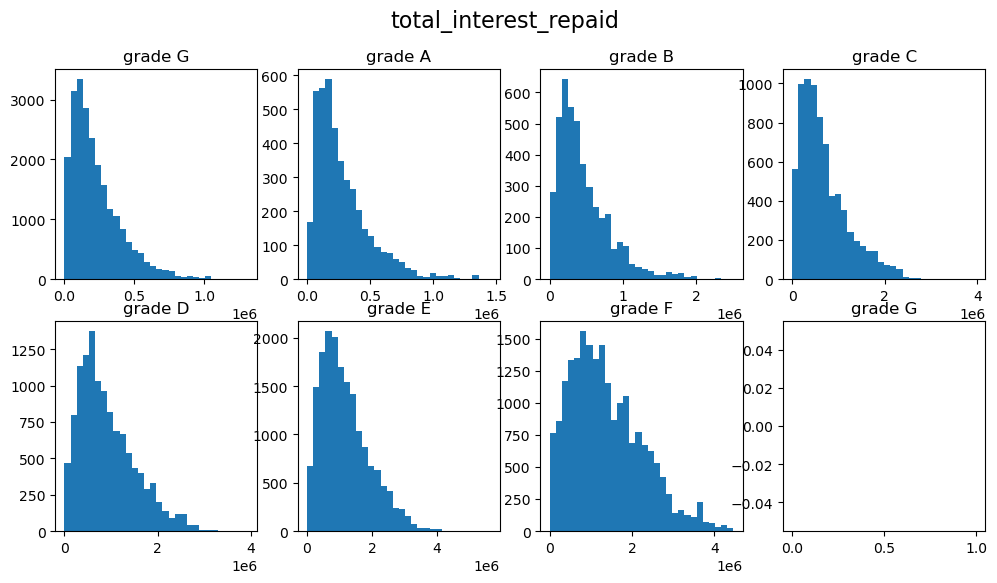

In [37]:
import seaborn as sns
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import zscore

# # 각 피처에 대해 Z-Score 계산
# z_scores = np.abs(zscore(train))

# # Z-Score가 특정 임계값을 넘어가는 데이터 제거 (예: 3을 사용)
# train = train[(z_scores < 3).all(axis=1)]

# 데이터를 훈련 세트와 테스트 세트로 나눕니다.
target = 'loan_grade'
cut_ratio = 0.2

X_train, X_test, y_train, y_test = train_test_split(train.drop(target,axis=1), train[[target]], test_size=0.2, stratify=train[[target]], random_state=42)

# 각 모델을 초기화합니다. (실제 데이터에 맞게 설정 필요)
lgbm = LGBMClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
catboost = CatBoostClassifier(random_state=42, verbose=0)

# 각 모델을 훈련합니다. (실제 데이터에 맞게 설정 필요)
lgbm.fit(X_train, y_train)
xgb.fit(X_train, y_train)
catboost.fit(X_train, y_train)

# 각 모델의 feature importance를 얻습니다.
lgbm_importance = lgbm.feature_importances_
xgb_importance = xgb.feature_importances_
catboost_importance = catboost.feature_importances_

# 각 모델의 feature importance를 합산합니다.
total_importance = lgbm_importance + xgb_importance + catboost_importance

# 중요도를 기준으로 상위 90%의 피쳐를 유지
threshold = np.percentile(total_importance, cut_ratio*100)
selected_features = X_train.columns[total_importance >= threshold]

# 유지된 피쳐를 기반으로 데이터를 업데이트
X_train = X_train[selected_features]
X_test = X_test[selected_features]
test = test[selected_features]

# 리샘플링 파이프라인 설정
resampling_pipeline = Pipeline([
    ('smote', SMOTE(random_state=1)),
    ('enn', EditedNearestNeighbours(n_neighbors=3))
])

# 리샘플링을 훈련 데이터에 적용
X_resampled, y_resampled = resampling_pipeline.fit_resample(X_train, y_train)
X_train = pd.concat([X_resampled,y_resampled],axis=1)

target = ['A','B','C','D','E','F','G']
    
def make_rpt(col):
    k = 0
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
    for i in range(2):
        for j in range(4):
            try:
                if k > len(target):
                    continue
                ax = axes[i, j]
                data = X_train[X_train['loan_grade'] == k][col]
                ax.hist(data,bins=30)
                ax.set_title(f'grade {target[k-1]}')
                k += 1
            except:pass
    plt.suptitle(col, fontsize=16)

for tar in test.columns:
    make_rpt(tar)
    plt.show()

In [38]:
X_train['loan_grade'].value_counts()

0    23054
6    20375
5    17640
4    11908
3     7505
2     4379
1     4210
Name: loan_grade, dtype: int64

In [9]:
# from pycaret.classification import *

# # PyCaret에서 사용할 데이터 프레임 생성 (실제 데이터에 맞게 설정 필요)
# # data = pd.concat([X_train, y_train], axis=1)

# # PyCaret의 setup 함수를 사용하여 실험 환경 설정
# exp1 = setup(X_train, target='loan_grade', fold=5, train_size=0.1, session_id=42)

# # 모델 비교
# best_model = compare_models(sort='F1', n_select=5) # , include=['lightgbm', 'xgboost', 'catboost'])

# # best_model로 훈련
# # final_model = finalize_model(best_model)

# # 테스트 데이터에 대한 예측
# # predictions = predict_model(final_model, data=X_test)

# # # Macro F1 Score 출력
# for md in best_model:
#     predictions = predict_model(md, data=X_test)
#     macro_f1_score = f1_score(y_test, predictions['prediction_label'], average='macro')
#     print(f"Macro F1 Score on Test Data: {macro_f1_score:.4f}")

,Description,Value
0,Session id,42
1,Target,loan_grade
2,Target type,Multiclass
3,Original data shape,"(35973, 11)"
4,Transformed data shape,"(35973, 11)"
5,Transformed train set shape,"(3597, 11)"
6,Transformed test set shape,"(32376, 11)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8463,0.9778,0.8463,0.8431,0.8408,0.7938,0.7945,0.1680
xgboost,Extreme Gradient Boosting,0.8374,0.9765,0.8374,0.8311,0.8316,0.7821,0.7827,0.5360
catboost,CatBoost Classifier,0.8368,0.9765,0.8368,0.8257,0.8259,0.7800,0.7813,3.1400
dt,Decision Tree Classifier,0.7832,0.8669,0.7832,0.7831,0.7825,0.7120,0.7122,0.0120
rf,Random Forest Classifier,0.8007,0.9680,0.8007,0.7791,0.7769,0.7277,0.7315,0.1640
gbc,Gradient Boosting Classifier,0.7873,0.9642,0.7873,0.7709,0.7712,0.7123,0.7149,1.0400
et,Extra Trees Classifier,0.7845,0.9633,0.7845,0.7586,0.7542,0.7038,0.7091,0.0940
qda,Quadratic Discriminant Analysis,0.7031,0.9279,0.7031,0.6768,0.6864,0.5982,0.5998,0.0100
lr,Logistic Regression,0.7123,0.9405,0.7123,0.6777,0.6833,0.6069,0.6110,0.8400
ada,Ada Boost Classifier,0.6191,0.8445,0.6191,0.6175,0.6113,0.4918,0.4959,0.0640


Macro F1 Score on Test Data: 0.5202


Macro F1 Score on Test Data: 0.5225


Macro F1 Score on Test Data: 0.4857


Macro F1 Score on Test Data: 0.5239


Macro F1 Score on Test Data: 0.3799


In [82]:
# from lightgbm import LGBMClassifier
# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
# from sklearn.metrics import f1_score
# from sklearn.ensemble import VotingClassifier
# from sklearn.model_selection import train_test_split
# import numpy as np

# # 데이터를 훈련 세트와 테스트 세트로 나눕니다.
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, stratify=y, random_state=42)

# # 각 모델을 초기화합니다. (실제 데이터에 맞게 설정 필요)
# lgbm = LGBMClassifier(random_state=42)
# xgb = XGBClassifier(random_state=42)
# catboost = CatBoostClassifier(random_state=42, verbose=0)

# # 각 모델을 훈련합니다. (실제 데이터에 맞게 설정 필요)
# lgbm.fit(X_train, y_train)
# xgb.fit(X_train, y_train)
# catboost.fit(X_train, y_train)

# # 각 모델의 feature importance를 얻습니다.
# lgbm_importance = lgbm.feature_importances_
# xgb_importance = xgb.feature_importances_
# catboost_importance = catboost.feature_importances_

# # 각 모델의 feature importance를 합산합니다.
# total_importance = lgbm_importance + xgb_importance + catboost_importance

# # 중요도를 기준으로 상위 90%의 피쳐를 유지
# threshold = np.percentile(total_importance, cut_ratio*100)
# selected_features = X_train.columns[total_importance >= threshold]

# # 유지된 피쳐를 기반으로 데이터를 업데이트
# X_train_selected = X_train[selected_features]
# X_test_selected = X_test[selected_features]

# # 업데이트된 데이터로 모델 재훈련
# lgbm.fit(X_train_selected, y_train)
# xgb.fit(X_train_selected, y_train)
# catboost.fit(X_train_selected, y_train)

# # 테스트 데이터에 대한 예측
# lgbm_pred = lgbm.predict(X_test_selected)
# xgb_pred = xgb.predict(X_test_selected)
# catboost_pred = catboost.predict(X_test_selected)

# # 각 모델의 F1 score를 계산합니다.
# lgbm_f1 = f1_score(y_test, lgbm_pred, average='macro')
# xgb_f1 = f1_score(y_test, xgb_pred, average='macro')
# catboost_f1 = f1_score(y_test, catboost_pred, average='macro')

# print(f"LGBM Macro F1 Score: {lgbm_f1:.4f}")
# print(f"XGBoost Macro F1 Score: {xgb_f1:.4f}")
# print(f"CatBoost Macro F1 Score: {catboost_f1:.4f}")


In [61]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from tqdm import tqdm
import numpy as np

train = pd.read_csv('./open/train.csv')
test = pd.read_csv('./open/test.csv')

train['대출기간'] = train['대출기간'].apply(lambda x:x[:3])
train['대출기간'] = train['대출기간'].astype('int64')
test['대출기간'] = test['대출기간'].apply(lambda x:x[:3])
test['대출기간'] = test['대출기간'].astype('int64')

trans = {'1 year':1,
 '1 years':1,
 '10+ years':10,
 '10+years':10,
 '2 years':2,
 '3':3,
 '3 years':3,
 '4 years':4,
 '5 years':5,
 '6 years':6,
 '7 years':7,
 '8 years':8,
 '9 years':9,
 '< 1 year':0.5,
 '<1 year':0.5,
 'Unknown':0}
train['근로기간'] = [trans[i] for i in train['근로기간'].values]
test['근로기간'] = [trans[i] for i in test['근로기간'].values]
# train.loc[train[train['부채_대비_소득_비율'] == 9999].index,'부채_대비_소득_비율'] = 2000
# test.loc[test[test['부채_대비_소득_비율'] == 9999].index,'부채_대비_소득_비율'] = 2000
# train = pd.get_dummies(train, columns=['주택소유상태','대출목적'])
# test = pd.get_dummies(test, columns=['주택소유상태','대출목적']) # c
# train = train.drop(['주택소유상태','대출목적','근로기간','연간소득','총계좌수','연체계좌수','총연체금액','최근_2년간_연체_횟수'],axis=1)
# test = test.drop(['주택소유상태','대출목적','근로기간','연간소득','총계좌수','연체계좌수','총연체금액','최근_2년간_연체_횟수'],axis=1)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for tt in ['주택소유상태','대출목적']:
    train[tt] = le.fit_transform(train[tt])
    test[tt] = le.fit_transform(test[tt])

train = train.drop('ID',axis=1)
test = test.drop('ID',axis=1)

target = ['A','B','C','D','E','F','G']
ordinal_mapping = {target[i]:i for i in range(len(target))}
train['대출등급'] = train['대출등급'].map(ordinal_mapping)

train.columns = ['loan_amount', 'loan_term', 'employment_duration', 'home_ownership_status', 
 'annual_income', 'debt_to_income_ratio', 'total_accounts', 'loan_purpose', 
 'recent_2_years_delinquency_count', 'total_principal_repaid', 'total_interest_repaid', 
 'total_overdue_amount', 'number_of_delinquent_accounts', 'loan_grade']
test.columns = ['loan_amount', 'loan_term', 'employment_duration', 'home_ownership_status', 
 'annual_income', 'debt_to_income_ratio', 'total_accounts', 'loan_purpose', 
 'recent_2_years_delinquency_count', 'total_principal_repaid', 'total_interest_repaid', 
 'total_overdue_amount', 'number_of_delinquent_accounts']

train = train.drop(['total_overdue_amount', 'number_of_delinquent_accounts', 'loan_purpose'],axis=1)
test = test.drop(['total_overdue_amount', 'number_of_delinquent_accounts', 'loan_purpose'],axis=1)

# # 각 피처에 대해 Z-Score 계산
# z_scores = zscore(train)

# # Z-Score가 특정 임계값을 넘어가는 데이터 제거 (예: 3을 사용)
# train = train[(z_scores < 3).all(axis=1)]

# 데이터를 훈련 세트와 테스트 세트로 나눕니다.
target = 'loan_grade'
cut_ratio = 0.2
test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(train.drop(target,axis=1), train[[target]], test_size=0.2, stratify=train[[target]], random_state=42)

# 각 모델을 초기화합니다. (실제 데이터에 맞게 설정 필요)
lgbm = LGBMClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
catboost = CatBoostClassifier(random_state=42, verbose=0)

# 각 모델을 훈련합니다. (실제 데이터에 맞게 설정 필요)
lgbm.fit(X_train, y_train)
xgb.fit(X_train, y_train)
catboost.fit(X_train, y_train)

# 각 모델의 feature importance를 얻습니다.
lgbm_importance = lgbm.feature_importances_
xgb_importance = xgb.feature_importances_
catboost_importance = catboost.feature_importances_

# 각 모델의 feature importance를 합산합니다.
total_importance = lgbm_importance + xgb_importance + catboost_importance

# 중요도를 기준으로 상위 90%의 피쳐를 유지
threshold = np.percentile(total_importance, cut_ratio*100)
selected_features = X_train.columns[total_importance >= threshold]

# 유지된 피쳐를 기반으로 데이터를 업데이트
X_train = X_train[selected_features]
X_test = X_test[selected_features]
test = test[selected_features]

# 리샘플링 파이프라인 설정
# resampling_pipeline = Pipeline([
# #    ('smote', SMOTE(random_state=1)),
#     ('enn', EditedNearestNeighbours(n_neighbors=3))
# ])

# # 리샘플링을 훈련 데이터에 적용
# X_resampled, y_resampled = resampling_pipeline.fit_resample(X_train, y_train)
# X_train = pd.concat([X_resampled,y_resampled],axis=1)


# 각 모델을 초기화합니다. (실제 데이터에 맞게 설정 필요)
lgbm = LGBMClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
catboost = CatBoostClassifier(random_state=42, verbose=0)
rf = RandomForestClassifier(random_state=42, oob_score=True)

# y_train = X_train[['loan_grade']]
# X_train = X_train.drop('loan_grade',axis=1)

# 각 모델을 훈련합니다. (실제 데이터에 맞게 설정 필요)
lgbm.fit(X_train, y_train)
xgb.fit(X_train, y_train)
catboost.fit(X_train, y_train)

# 소프트 보팅 앙상블 모델 생성
ensemble_model = VotingClassifier(estimators=[
    ('lgbm', lgbm),
    ('xgb', xgb),
    ('catboost', catboost),
#    ('rf', rf)
], voting='soft')

# Cross validation을 위한 StratifiedKFold 사용
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=4)

# f1_score를 평가 지표로 사용
scorer = make_scorer(f1_score, average='macro')

# 각 모델과 앙상블 모델에 대해 cross validation 수행
lgbm_cv_scores = cross_val_score(lgbm, X_test, y_test, cv=cv, scoring=scorer, n_jobs=-1)
xgb_cv_scores = cross_val_score(xgb, X_test, y_test, cv=cv, scoring=scorer, n_jobs=-1)
catboost_cv_scores = cross_val_score(catboost, X_test, y_test, cv=cv, scoring=scorer, n_jobs=-1)
# rf_cv_scores = cross_val_score(rf, X_test, y_test, cv=cv, scoring=scorer, n_jobs=-1)
ensemble_cv_scores = cross_val_score(ensemble_model, X_test, y_test, cv=cv, scoring=scorer, n_jobs=-1)

# 결과 출력
print(f"LGBM Cross Validation Macro F1 Scores: {np.mean(lgbm_cv_scores)}")
print(f"XGBoost Cross Validation Macro F1 Scores: {np.mean(xgb_cv_scores)}")
print(f"CatBoost Cross Validation Macro F1 Scores: {np.mean(catboost_cv_scores)}")
# print(f"RamdomForest Cross Validation Macro F1 Scores: {np.mean(rf_cv_scores)}")
print(f"Ensemble Model Cross Validation Macro F1 Scores: {np.mean(ensemble_cv_scores)}")


C:\Users\User\anaconda3\envs\project\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\anaconda3\envs\project\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\User\anaconda3\envs\project\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\anaconda3\envs\project\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y

LGBM Cross Validation Macro F1 Scores: 0.7068174258106221
XGBoost Cross Validation Macro F1 Scores: 0.7301920551588083
CatBoost Cross Validation Macro F1 Scores: 0.6403507032012387
Ensemble Model Cross Validation Macro F1 Scores: 0.7176091378324638


In [62]:
sub = pd.read_csv('./open/sample_submission.csv')
sub['대출등급'] = xgb.predict(test)
target = ['A','B','C','D','E','F','G']
ordinal_mapping = {i:target[i] for i in range(len(target))}
sub['대출등급'] = sub['대출등급'].map(ordinal_mapping)
sub = sub.set_index('ID')
sub.to_csv('./xgb.csv')

In [63]:
sub['대출등급'].value_counts()

B    19519
C    18665
A    11169
D     8797
E     4617
F     1231
G      199
Name: 대출등급, dtype: int64